In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lingua import Language, LanguageDetectorBuilder
from sacrebleu.metrics import BLEU
from datasets import load_dataset
import math
import os

In [94]:
srcs = ["../eval_results/flores/7B",
        "../eval_results/flores/8B",
        "../eval_results/flores/3B",]

model_names = ["LLaMA 2 7B Chat",
               "LLaMA 3.1 8B Instruct",
               "LLaMA 3.2 3B Instruct",]

In [95]:
langs = [
    ("fr", Language.FRENCH),
    ("ru", Language.RUSSIAN),
    ("uk", Language.UKRAINIAN), 
    ("es", Language.SPANISH), 
    ("vi", Language.VIETNAMESE), 
    ("id", Language.INDONESIAN),
    ("zh", Language.CHINESE),
    ("hi", Language.HINDI),
]

languages = [
    Language.ENGLISH, 
    Language.FRENCH, 
    Language.SPANISH, 
    Language.UKRAINIAN, 
    Language.RUSSIAN, 
    Language.VIETNAMESE, 
    Language.INDONESIAN, 
    Language.CHINESE, 
    Language.HINDI,
]

detector = LanguageDetectorBuilder.from_languages(*languages).build()

def get_filter(l_code, column_name):
    def lang_filter(row):
        return detector.detect_language_of(str(row[column_name])) == l_code
    return lang_filter

quants = [
    ("hf", "16"),
    ("hf", "4"),
    ("rtn", "4"),
    ("awq", "4"),
    ("gptq", "4"),
]

bleu = BLEU(tokenize="flores101")

In [96]:
data_files = {
    "en": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.eng_Latn",
    "fr": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.fra_Latn",
    "ru": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.rus_Cyrl",
    "es": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.spa_Latn",
    "uk": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.ukr_Cyrl",
    "vi": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.vie_Latn",
    "id": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.ind_Latn",
    "hi": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.hin_Deva",
    "zh": f"../../Eval/floresp-v2.0-rc.3/devtest/devtest.cmn_Hans",
}

reference_data = load_dataset("text", data_files=data_files)

In [97]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metric = "count"

res_to = []
for src in srcs:
    to_merge = None
    for method, precision in quants:
        merge = None
        for lang, l_code in langs:
            data = pd.read_csv(f"{src}/{lang}/{method}_{precision}.csv", index_col=0)
            # data = data[data.apply(get_filter(l_code), axis=1)]
            data[target_metric] = data.apply(get_filter(l_code, "to"), axis=1).sum()
            data[lang_col_name] = lang
            if merge is None:
                merge = data
            else:
                merge = pd.concat([merge, data])
        merge[quant_col_name] = f"{method} {precision}bit"
        if to_merge is None:
            to_merge = merge
        else:
            to_merge = pd.concat([to_merge, merge])
    res_to.append(to_merge)

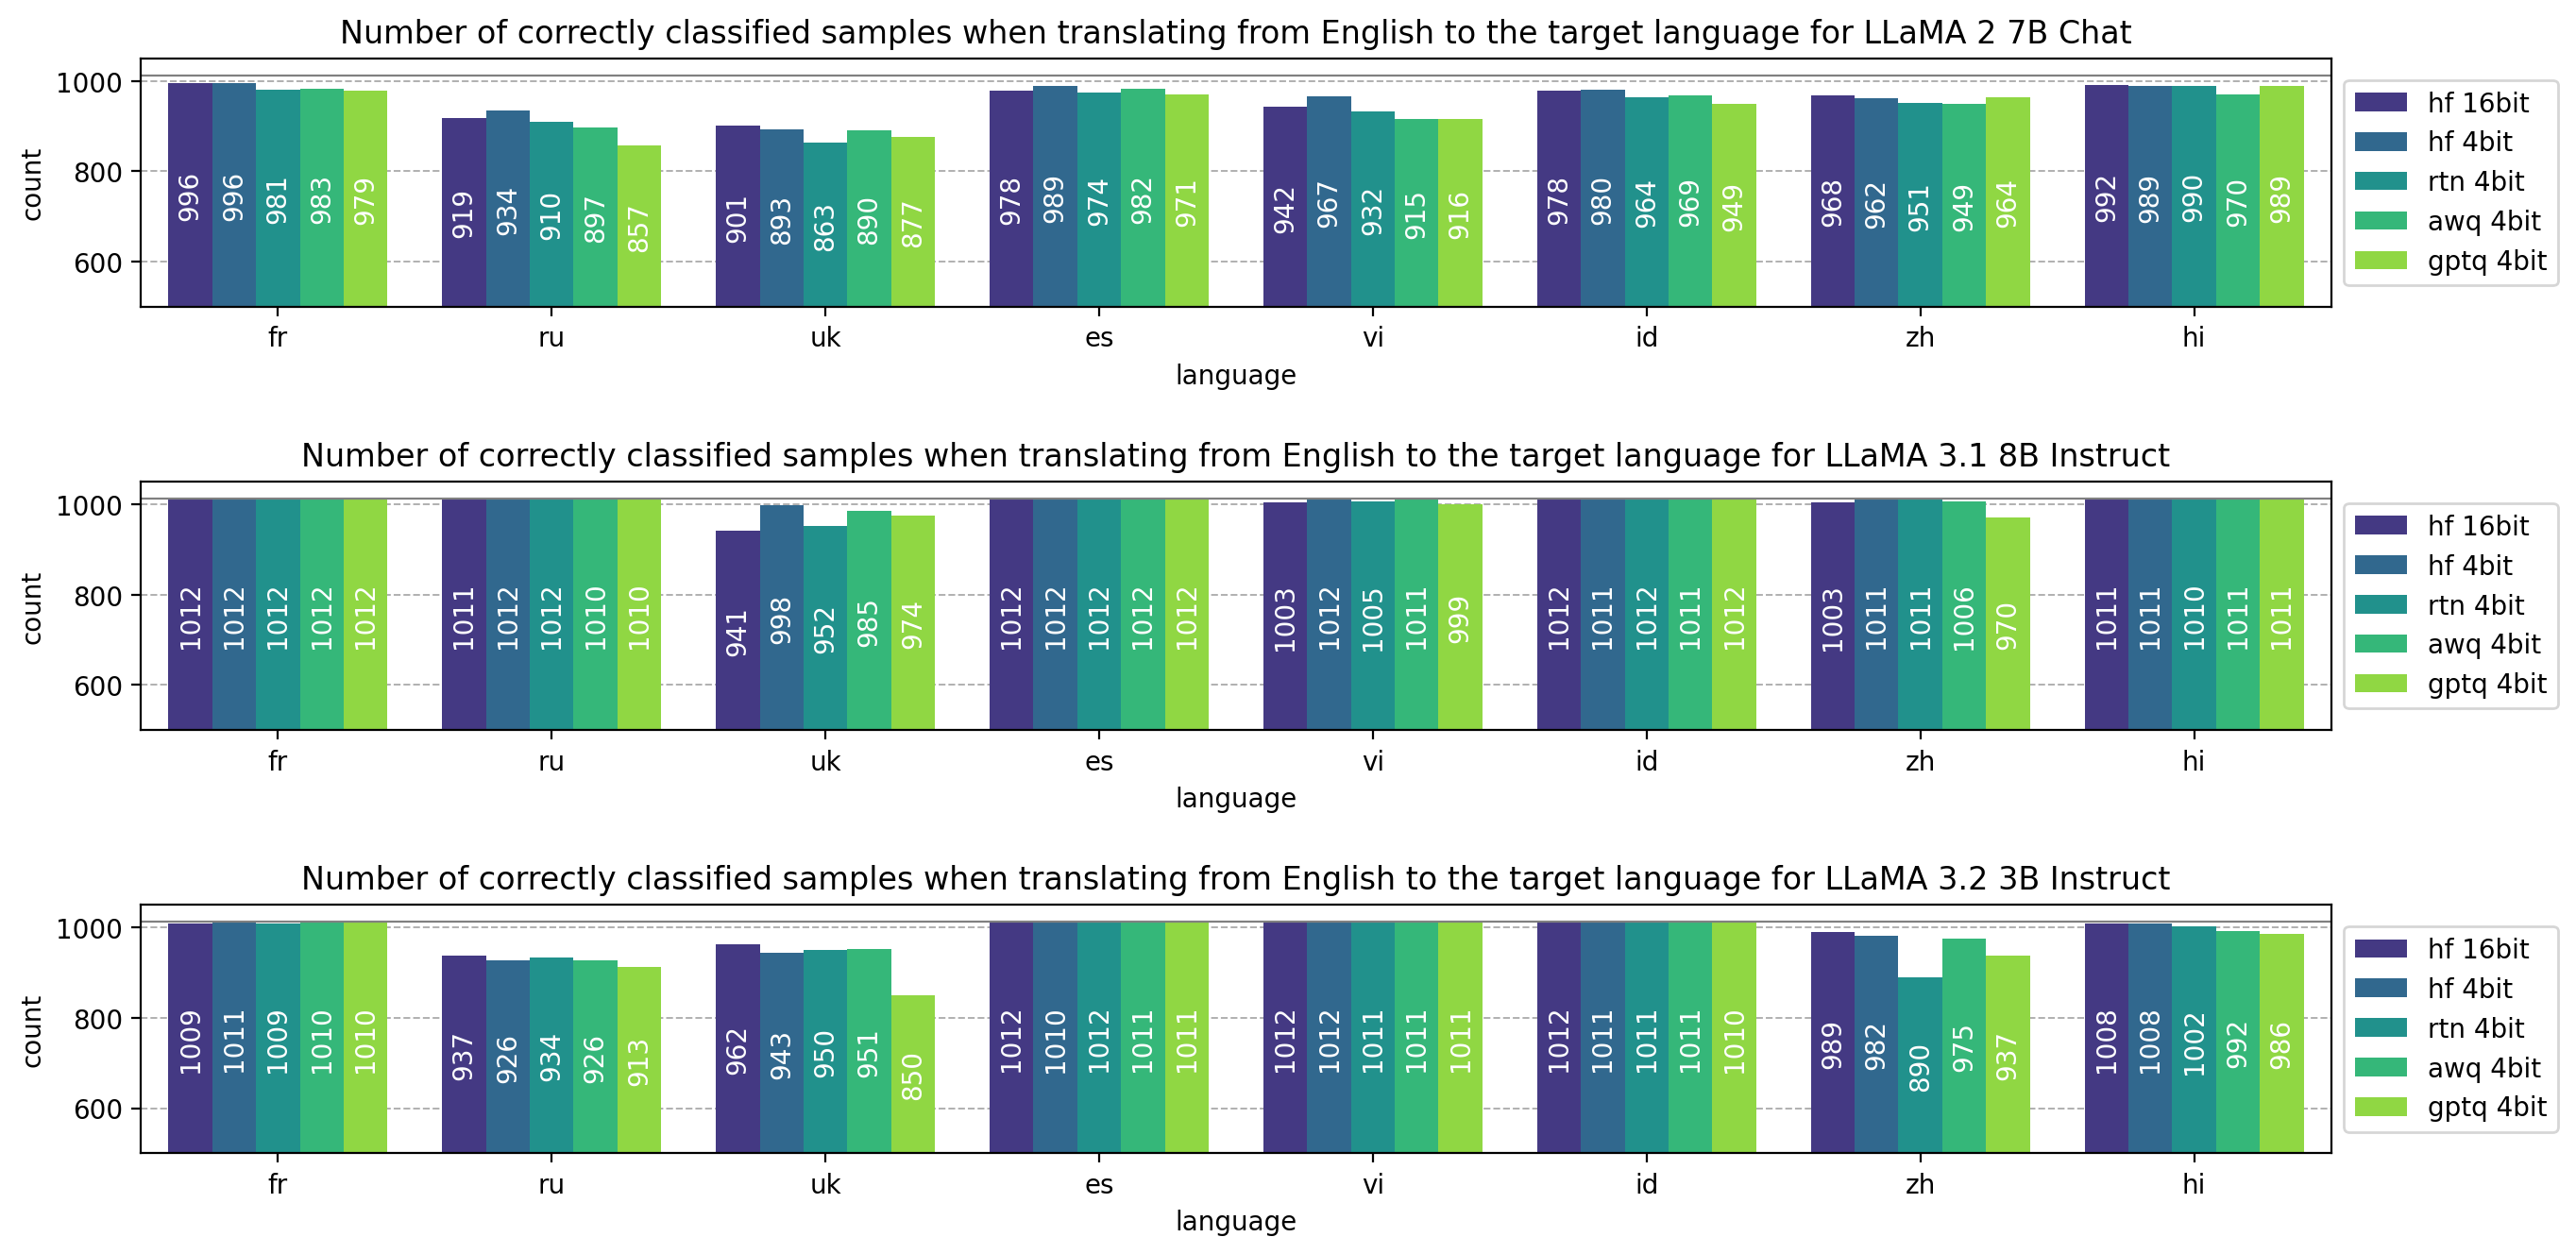

In [98]:
fig, axs = plt.subplots(nrows=3, figsize=(14, 7), dpi=200)

for n in range(3):
    ax = axs[n]
    m_name = model_names[n]
    to_merge = res_to[n]

    ax.axhline(y=1012, color='gray', linestyle='-', linewidth=0.8)
    ax.set_ylim(500, 1050)
    ax = sns.barplot(x=lang_col_name, y=target_metric, hue=quant_col_name, palette="viridis", data=to_merge, saturation=1, ax=ax)
    for container in ax.containers:
        labels = ax.bar_label(container, label_type="center", color="white")
        for label in labels:
            label.set_rotation(90)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
    ax.set_axisbelow(True)
    ax.set_title(f"Number of correctly classified samples when translating from English to the target language for {m_name}")

plt.tight_layout(pad=2)
plt.show()

In [99]:
lang_col_name = "language"
quant_col_name = "Model quants:"
target_metric = "count"

res_from = []
for src in srcs:
    from_merge = None
    for method, precision in quants:
        merge = None
        for lang, l_code in langs:
            data = pd.read_csv(f"{src}/{lang}/{method}_{precision}.csv", index_col=0)
            # data = data[data.apply(get_filter(l_code), axis=1)]
            data[target_metric] = data.apply(get_filter(Language.ENGLISH, "from"), axis=1).sum()
            data[lang_col_name] = lang
            if merge is None:
                merge = data
            else:
                merge = pd.concat([merge, data])
        merge[quant_col_name] = f"{method} {precision}bit"
        if from_merge is None:
            from_merge = merge
        else:
            from_merge = pd.concat([from_merge, merge])
    res_from.append(from_merge)

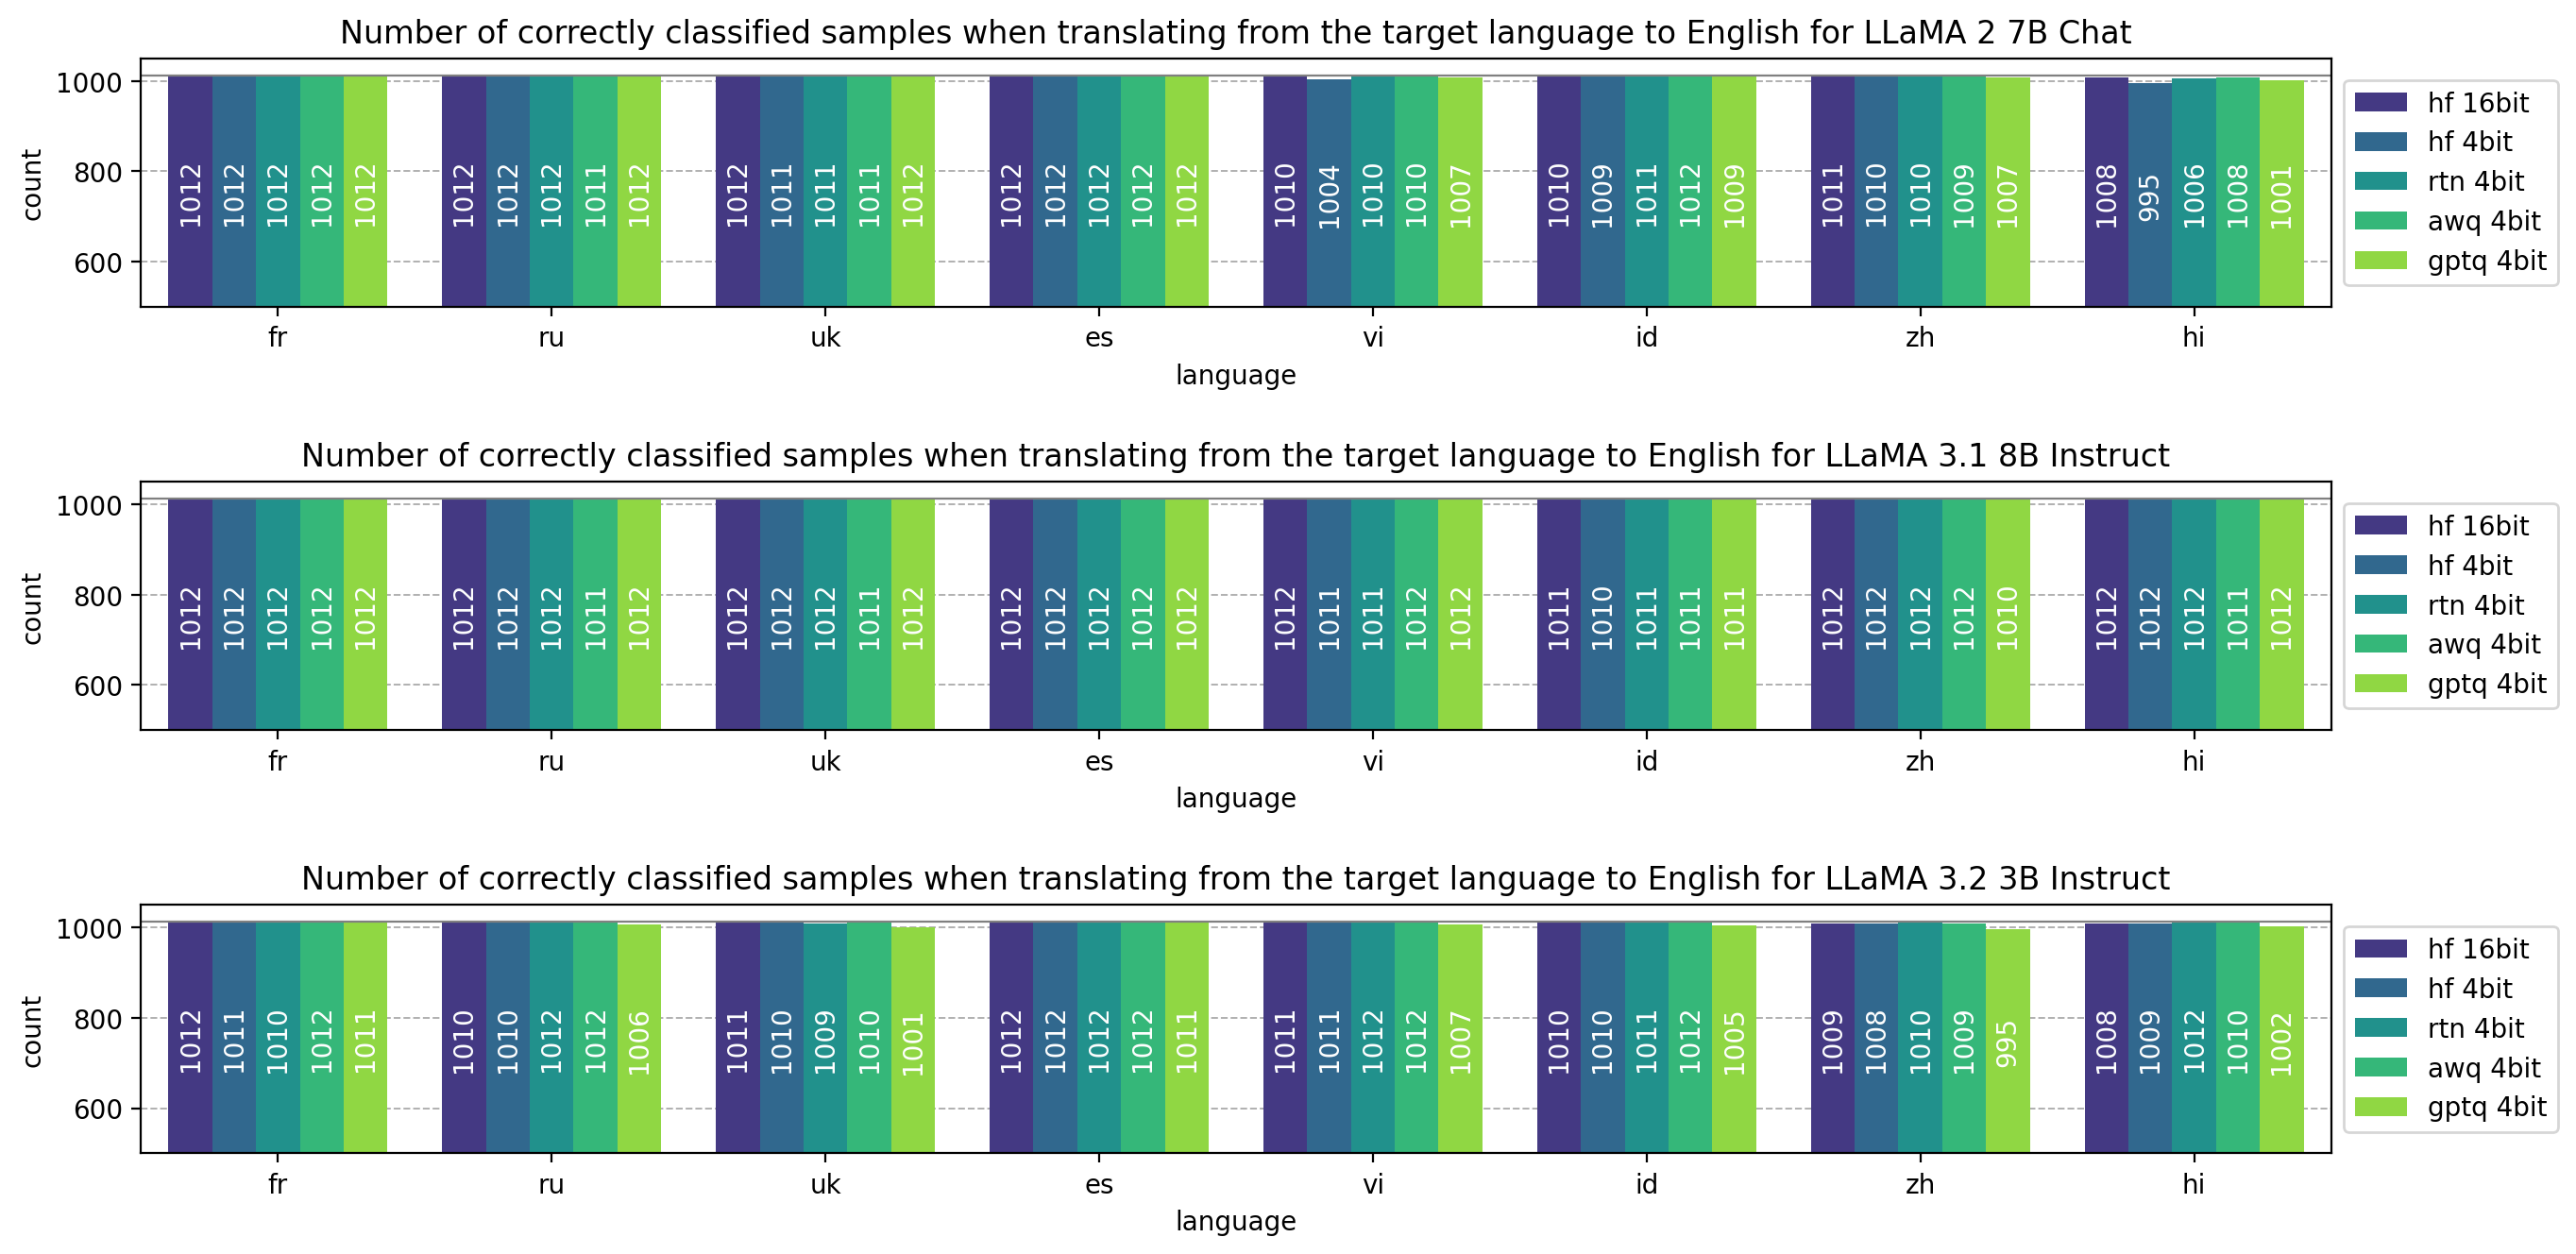

In [100]:
fig, axs = plt.subplots(nrows=3, figsize=(14, 7), dpi=200)

for n in range(3):
    ax = axs[n]
    m_name = model_names[n]
    from_merge = res_from[n]

    ax.axhline(y=1012, color='gray', linestyle='-', linewidth=0.8)
    ax.set_ylim(500, 1050)
    ax = sns.barplot(x=lang_col_name, y=target_metric, hue=quant_col_name, palette="viridis", data=from_merge, saturation=1, ax=ax)
    for container in ax.containers:
        labels = ax.bar_label(container, label_type="center", color="white")
        for label in labels:
            label.set_rotation(90)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
    ax.set_axisbelow(True)
    ax.set_title(f"Number of correctly classified samples when translating from the target language to English for {m_name}")

plt.tight_layout(pad=2)
plt.show()

In [110]:
bleus = []

for src in srcs:
    if not os.path.exists(f"{src}/BLEU.csv"):

        bleu_summary_avg = None
        columns = ["quant", "language", "BLEU", "direction"]

        count = 0

        for method, precision in quants:
            ref_reverse = reference_data["en"]["text"]
            for lang, l_code in langs:
                data = pd.read_csv(f"{src}/{lang}/{method}_{precision}.csv", index_col=0)

                ref = reference_data[lang]["text"]

                list_to = data["to"].to_list()
                list_from = data["from"].to_list()

                for n in range(len(ref_reverse)):
                    # print(n, lang, method, precision)

                    if (type(list_to[n]) == float) and math.isnan(list_to[n]): bleu_to = 0
                    else: bleu_to = bleu.corpus_score([list_to[n]], [[ref[n]]]).score

                    if (type(list_from[n]) == float) and math.isnan(list_from[n]): bleu_from = 0
                    else: bleu_from = bleu.corpus_score([list_from[n]], [[ref_reverse[n]]]).score

                    line = pd.DataFrame([
                        [f"{method} {precision}bit", lang, bleu_to, "to"], 
                        [f"{method} {precision}bit", lang, bleu_from, "from"]
                        ], columns=columns)
                
                    if bleu_summary_avg is None:
                        bleu_summary_avg = line
                    else:
                        bleu_summary_avg = pd.concat([bleu_summary_avg, line], axis=0, ignore_index=True)

        bleu_summary_avg.to_csv(f"{src}/BLEU.csv")

    else:
        bleu_summary_avg = pd.read_csv(f"{src}/BLEU.csv", index_col=0)
    bleus.append(bleu_summary_avg)

bleus[0]

,quant,language,BLEU,direction
0,hf 16bit,fr,26.848384,to
1,hf 16bit,fr,59.009730,from
2,hf 16bit,fr,56.976641,to
3,hf 16bit,fr,58.391361,from
4,hf 16bit,fr,13.011055,to
...,...,...,...,...
80955,gptq 4bit,hi,18.226811,from
80956,gptq 4bit,hi,2.776853,to
80957,gptq 4bit,hi,1.493370,from
80958,gptq 4bit,hi,2.400354,to


In [115]:
table_bleus = []
for bleu_summary_avg in bleus:
    to_pivoted = bleu_summary_avg[bleu_summary_avg["direction"]=="to"].pivot_table(index="quant", columns="language", values="BLEU", aggfunc='mean')
    to_pivoted = to_pivoted.div(to_pivoted.iloc[2]).subtract(1).mul(100)
    to_pivoted = to_pivoted.drop("hf 16bit")
    to_pivoted['mean'] = to_pivoted.mean(numeric_only=True, axis=1)
    to_pivoted.loc["mean_to"] = to_pivoted.mean()

    from_pivoted = bleu_summary_avg[bleu_summary_avg["direction"]=="from"].pivot_table(index="quant", columns="language", values="BLEU", aggfunc='mean')
    from_pivoted = from_pivoted.div(from_pivoted.iloc[2]).subtract(1).mul(100)
    from_pivoted = from_pivoted.drop("hf 16bit")
    from_pivoted['mean'] = from_pivoted.mean(numeric_only=True, axis=1)
    from_pivoted.loc["mean_from"] = from_pivoted.mean()

    all_pivoted = pd.concat([to_pivoted, from_pivoted])
    all_pivoted.loc["mean"] = all_pivoted.mean()

    table_bleus.append(all_pivoted)

# print(all_pivoted.to_latex(float_format='%.2f\%%'))

In [118]:
print(table_bleus[2].to_latex(float_format='%.2f\%%'))

\begin{tabular}{lrrrrrrrrr}
\toprule
language & es & fr & hi & id & ru & uk & vi & zh & mean \\
quant &  &  &  &  &  &  &  &  &  \\
\midrule
awq 4bit & -2.32\% & -1.46\% & -6.33\% & -3.56\% & -8.41\% & -9.18\% & -3.16\% & -6.24\% & -5.08\% \\
gptq 4bit & -3.35\% & -5.84\% & -12.52\% & -9.46\% & -11.86\% & -27.45\% & -7.92\% & -13.30\% & -11.46\% \\
hf 4bit & -2.67\% & -5.98\% & -9.66\% & -8.47\% & -13.42\% & -19.81\% & -7.01\% & -12.31\% & -9.92\% \\
rtn 4bit & -1.65\% & -3.03\% & -5.94\% & -5.34\% & -6.36\% & -11.53\% & -4.53\% & -14.91\% & -6.66\% \\
mean_to & -2.50\% & -4.08\% & -8.61\% & -6.71\% & -10.01\% & -16.99\% & -5.66\% & -11.69\% & -8.28\% \\
awq 4bit & -1.05\% & -0.75\% & -4.70\% & -3.01\% & -1.52\% & -4.70\% & -1.29\% & -3.38\% & -2.55\% \\
gptq 4bit & -3.91\% & -3.77\% & -10.72\% & -6.52\% & -7.49\% & -10.12\% & -5.68\% & -7.56\% & -6.97\% \\
hf 4bit & -0.85\% & -2.05\% & -9.21\% & -6.05\% & -3.60\% & -7.38\% & -5.77\% & -5.39\% & -5.04\% \\
rtn 4bit & -3.18\% & -1.27\% 

In [ ]:
# Moved generation to separate script
comets = []
for src in srcs:
    comet_summary_avg = pd.read_csv(f"{src}/COMET.csv", index_col=0)
    comets.append(comet_summary_avg)

In [ ]:
table_comets = []
for comet_summary_avg in comets:
    to_pivoted = comet_summary_avg[comet_summary_avg["direction"]=="to"].pivot_table(index="quant", columns="language", values="COMET", aggfunc='mean')
    to_pivoted = to_pivoted.div(to_pivoted.iloc[3]).subtract(1).mul(100)
    to_pivoted = to_pivoted.drop("hf 16bit")
    to_pivoted['mean'] = to_pivoted.mean(numeric_only=True, axis=1)

    from_pivoted = comet_summary_avg[comet_summary_avg["direction"]=="from"].pivot_table(index="quant", columns="language", values="COMET", aggfunc='mean')
    from_pivoted = from_pivoted.div(from_pivoted.iloc[3]).subtract(1).mul(100)
    from_pivoted = from_pivoted.drop("hf 16bit")
    from_pivoted['mean'] = from_pivoted.mean(numeric_only=True, axis=1)

    all_pivoted = pd.concat([to_pivoted, from_pivoted])
    all_pivoted.loc["mean"] = all_pivoted.mean()

# print(all_pivoted.to_latex(float_format='%.2f\%%'))

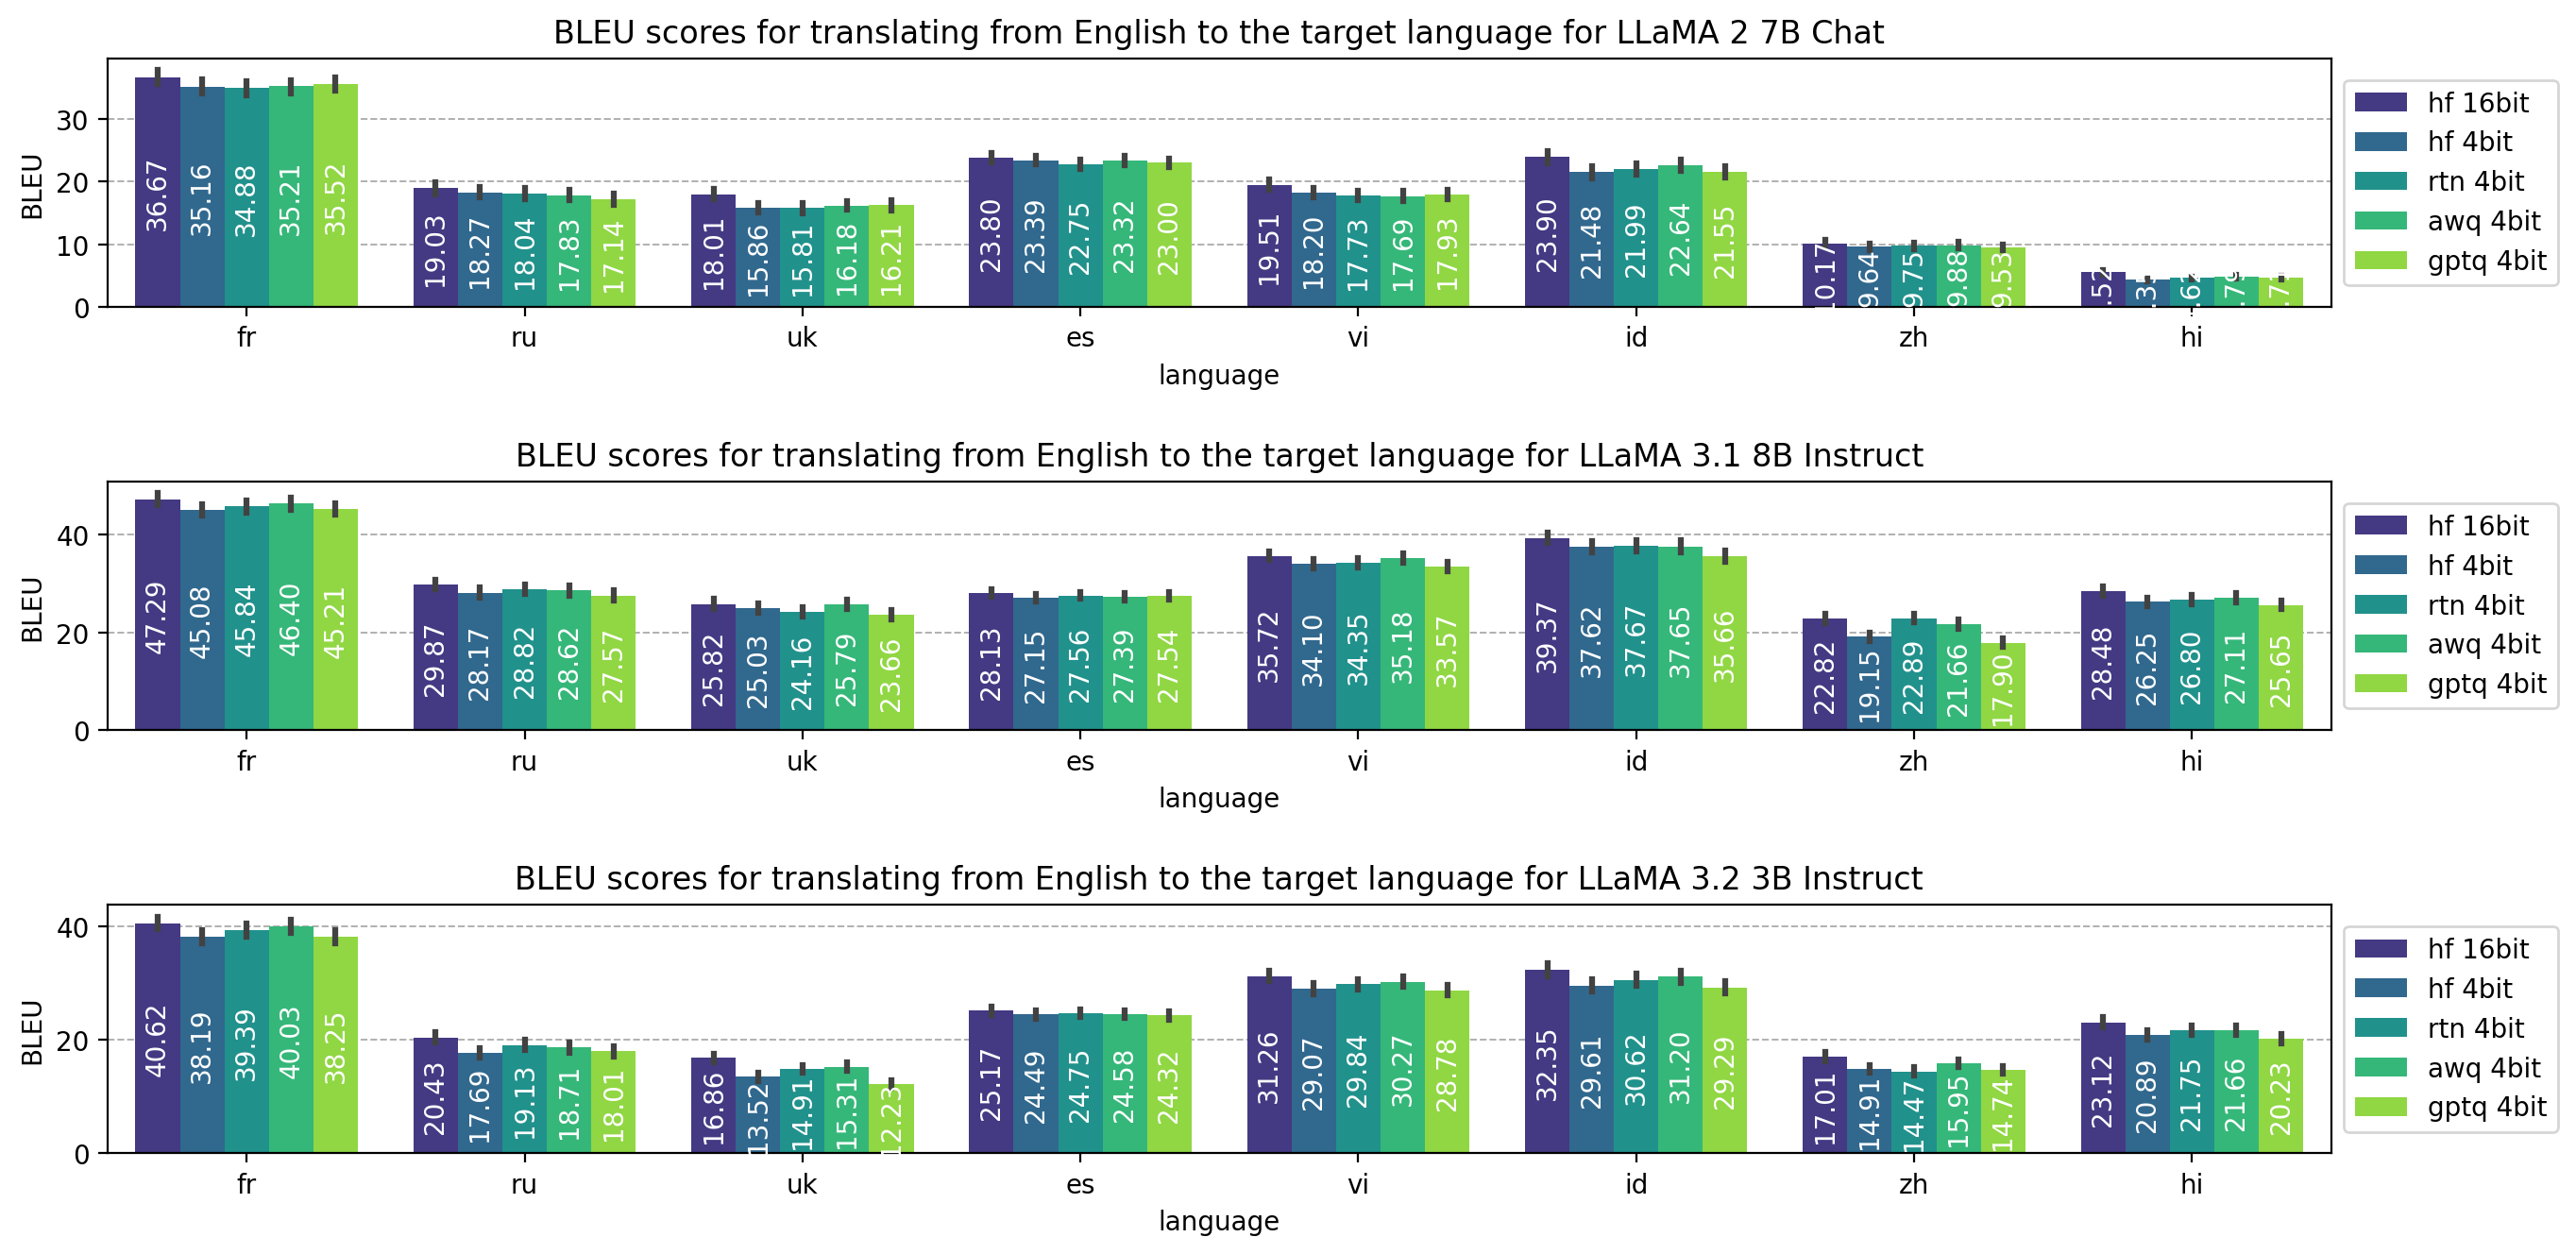

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(14, 7), dpi=200)

for n in range(3):
    ax = axs[n]
    bleu_summary_avg = bleus[n]
    m_name = model_names[n]

    ax = sns.barplot(x="language", y="BLEU", hue="quant", palette="viridis", data=bleu_summary_avg[bleu_summary_avg["direction"]=="to"], saturation=1, ax=ax)
    for container in ax.containers:
        labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
        for label in labels:
            label.set_rotation(90)
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
    ax.set_axisbelow(True)
    ax.set_title(f"BLEU scores for translating from English to the target language for {m_name}")

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(pad=2.0)
plt.show()

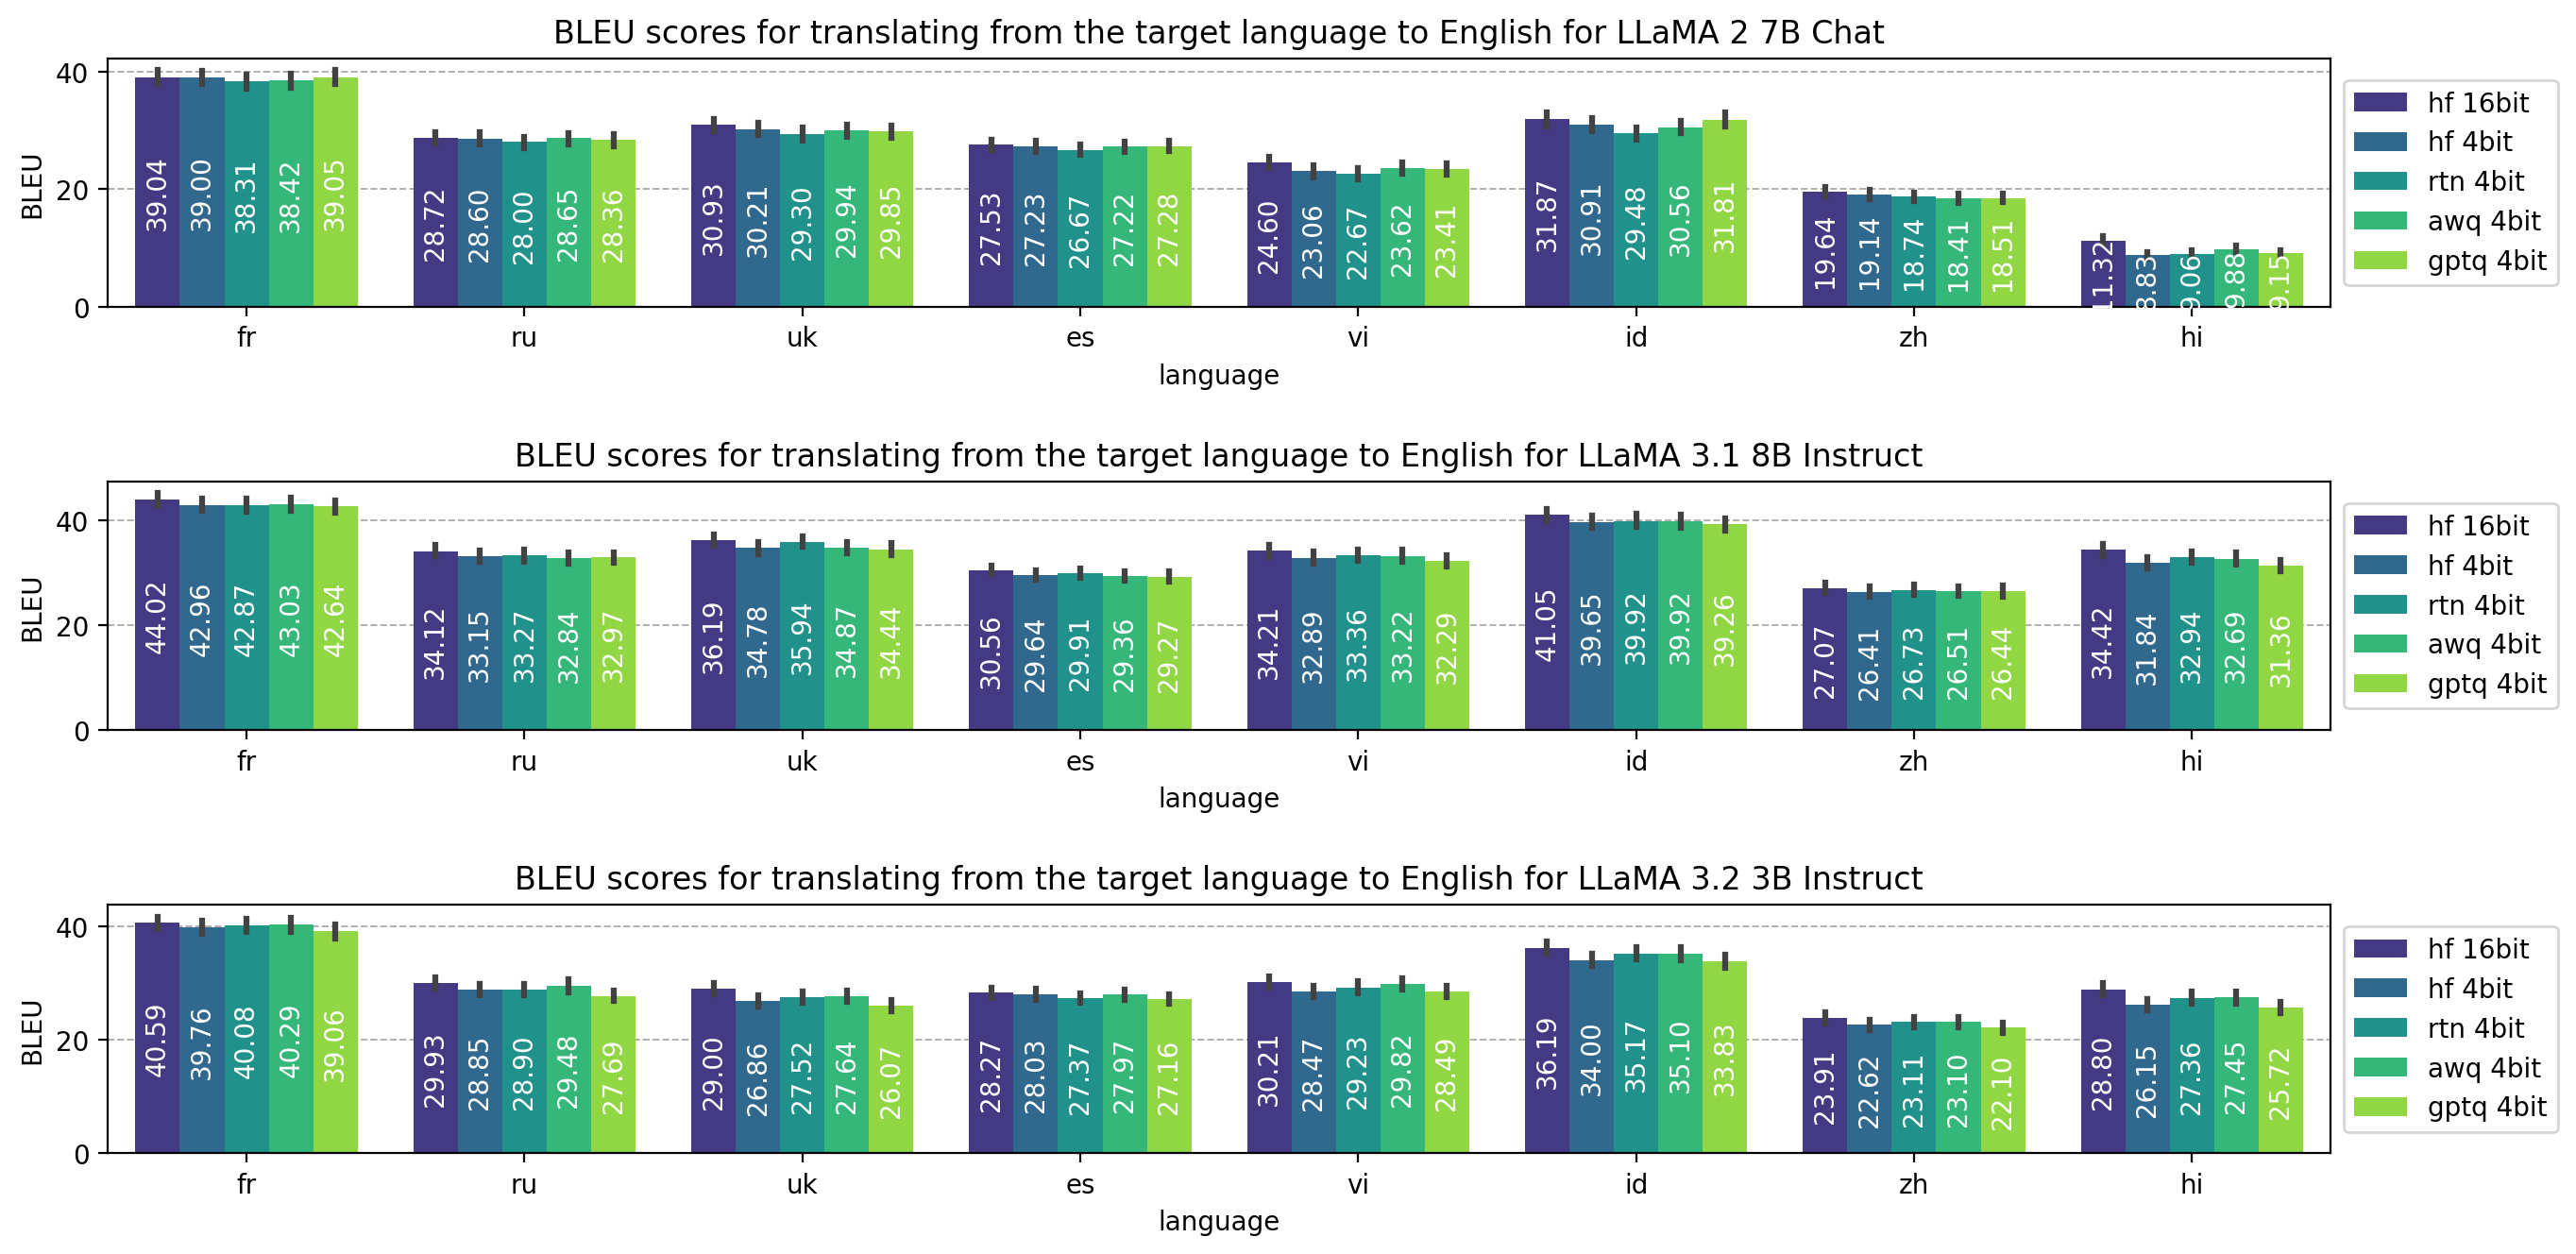

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(14, 7), dpi=200)

for n in range(3):
    ax = axs[n]
    bleu_summary_avg = bleus[n]
    m_name = model_names[n]

    ax = sns.barplot(x="language", y="BLEU", hue="quant", palette="viridis", data=bleu_summary_avg[bleu_summary_avg["direction"]=="from"], saturation=1, ax=ax)
    for container in ax.containers:
        labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
        for label in labels:
            label.set_rotation(90)
    ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
    ax.set_axisbelow(True)
    ax.set_title(f"BLEU scores for translating from the target language to English for {m_name}")

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(pad=2.0)
plt.show()

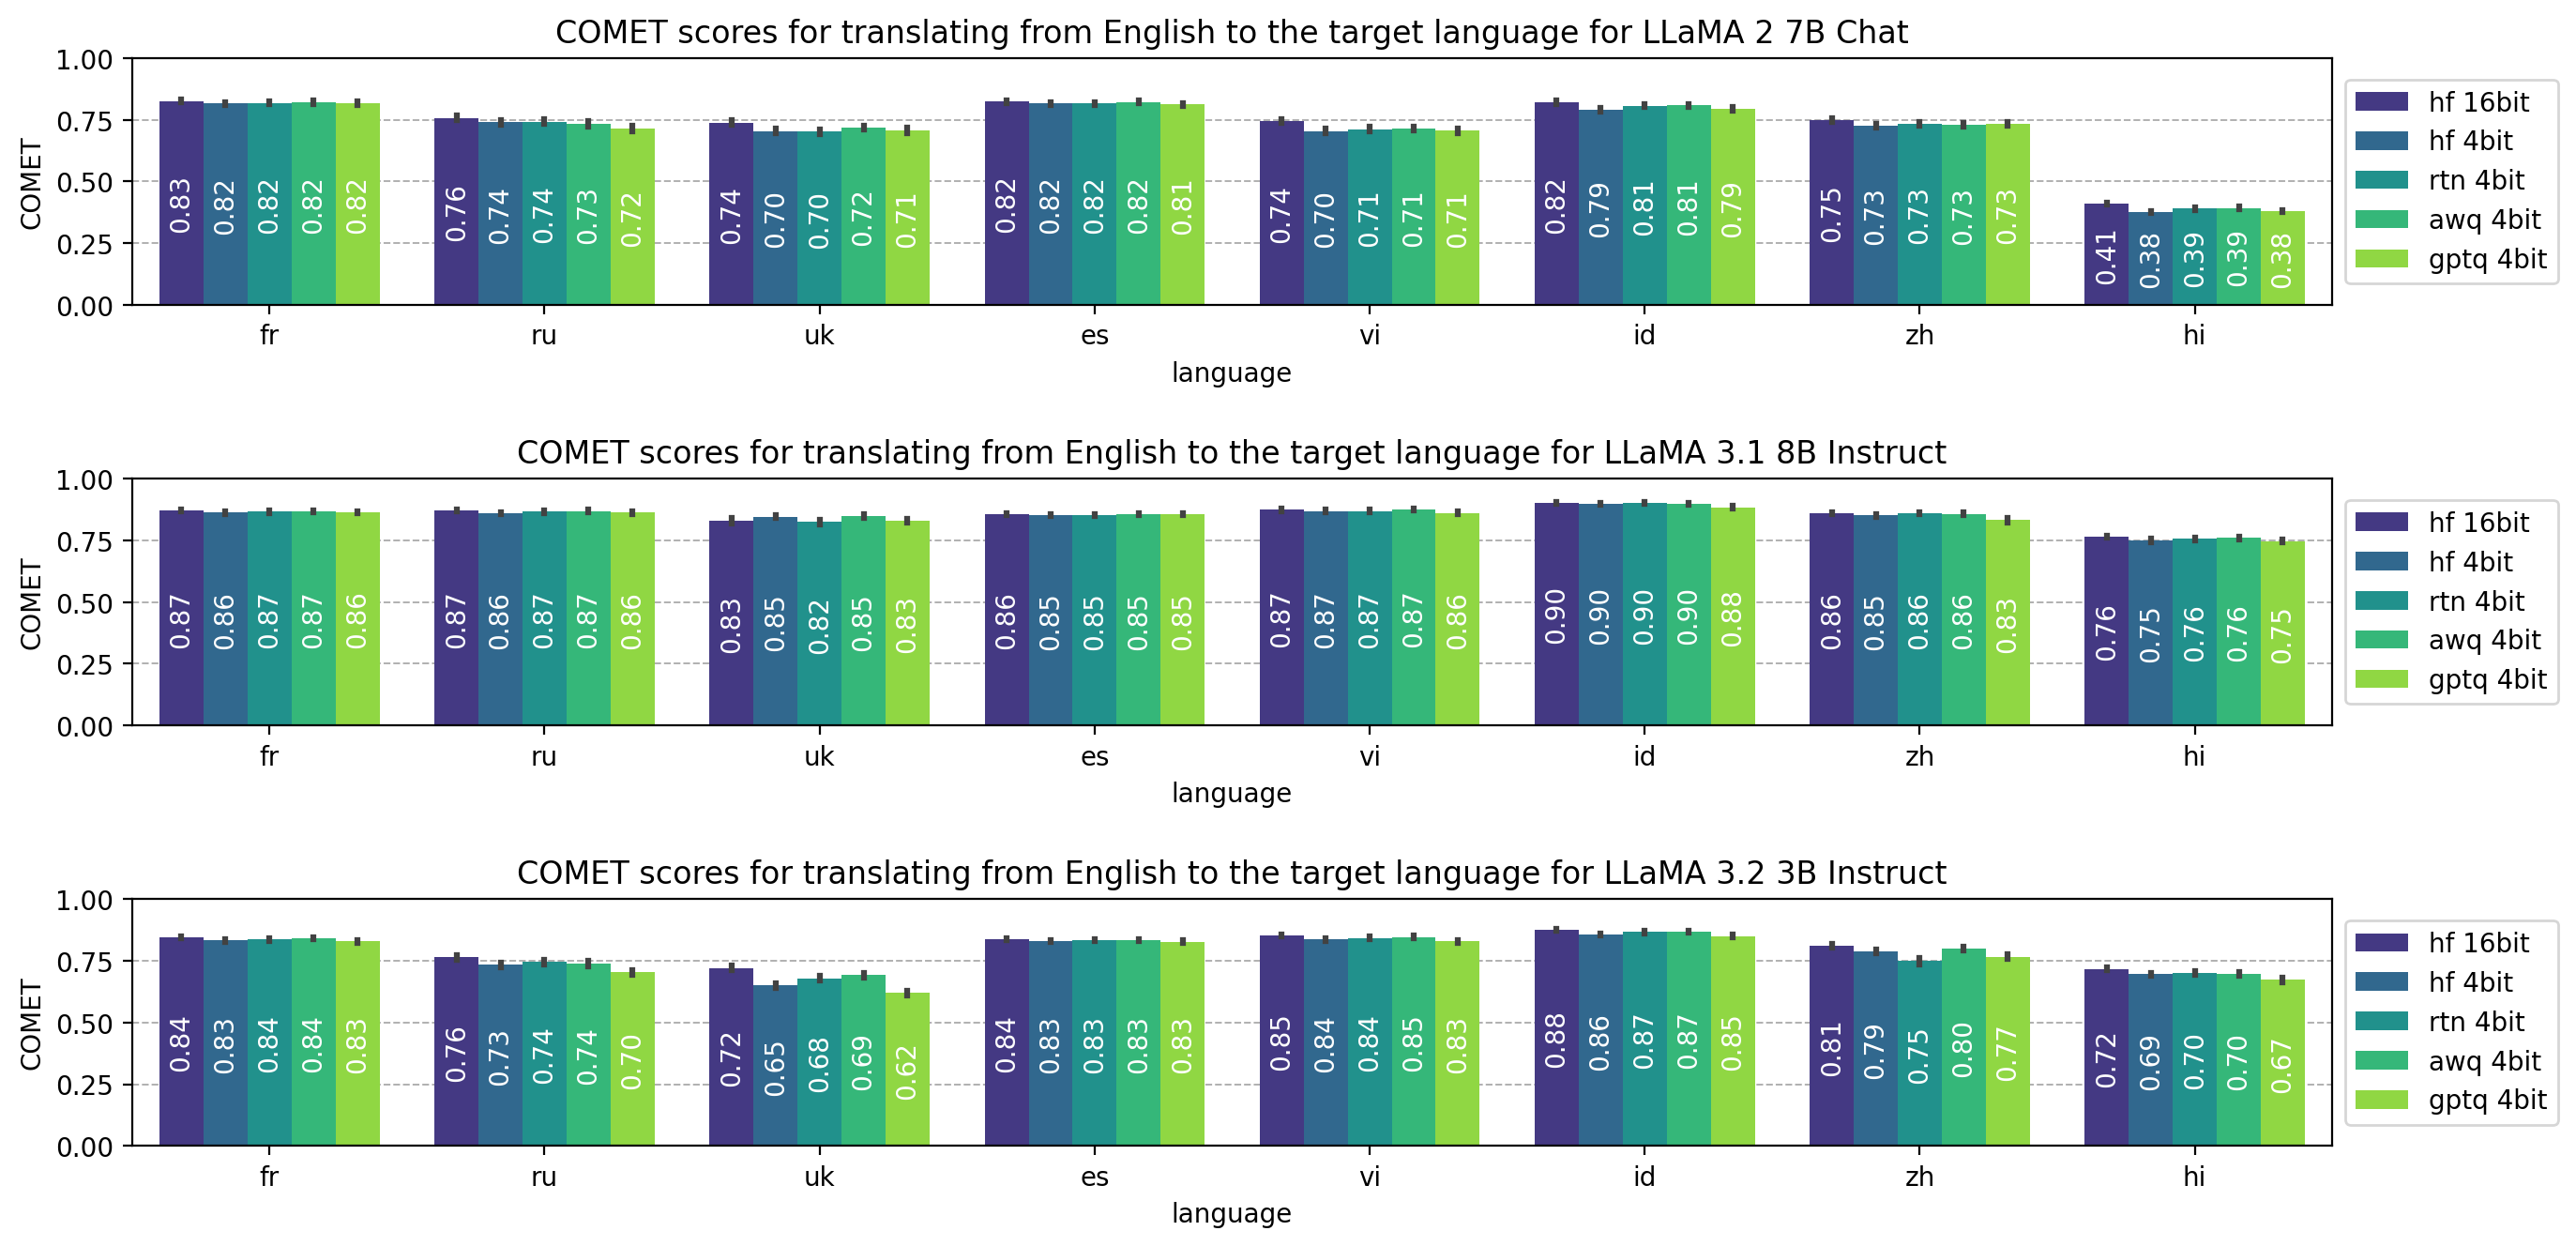

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(14, 7), dpi=200)

for n in range(3):
    ax = axs[n]
    comet_summary_avg = comets[n]
    m_name = model_names[n]

    ax = sns.barplot(x="language", y="COMET", hue="quant", palette="viridis", data=comet_summary_avg[comet_summary_avg["direction"]=="to"], saturation=1, ax=ax)
    for container in ax.containers:
        labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
        for label in labels:
            label.set_rotation(90)
    ax.set_ylim(0, 1)
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
    ax.set_axisbelow(True)
    ax.set_title(f"COMET scores for translating from English to the target language for {m_name}")

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(pad=2.0)
plt.show()

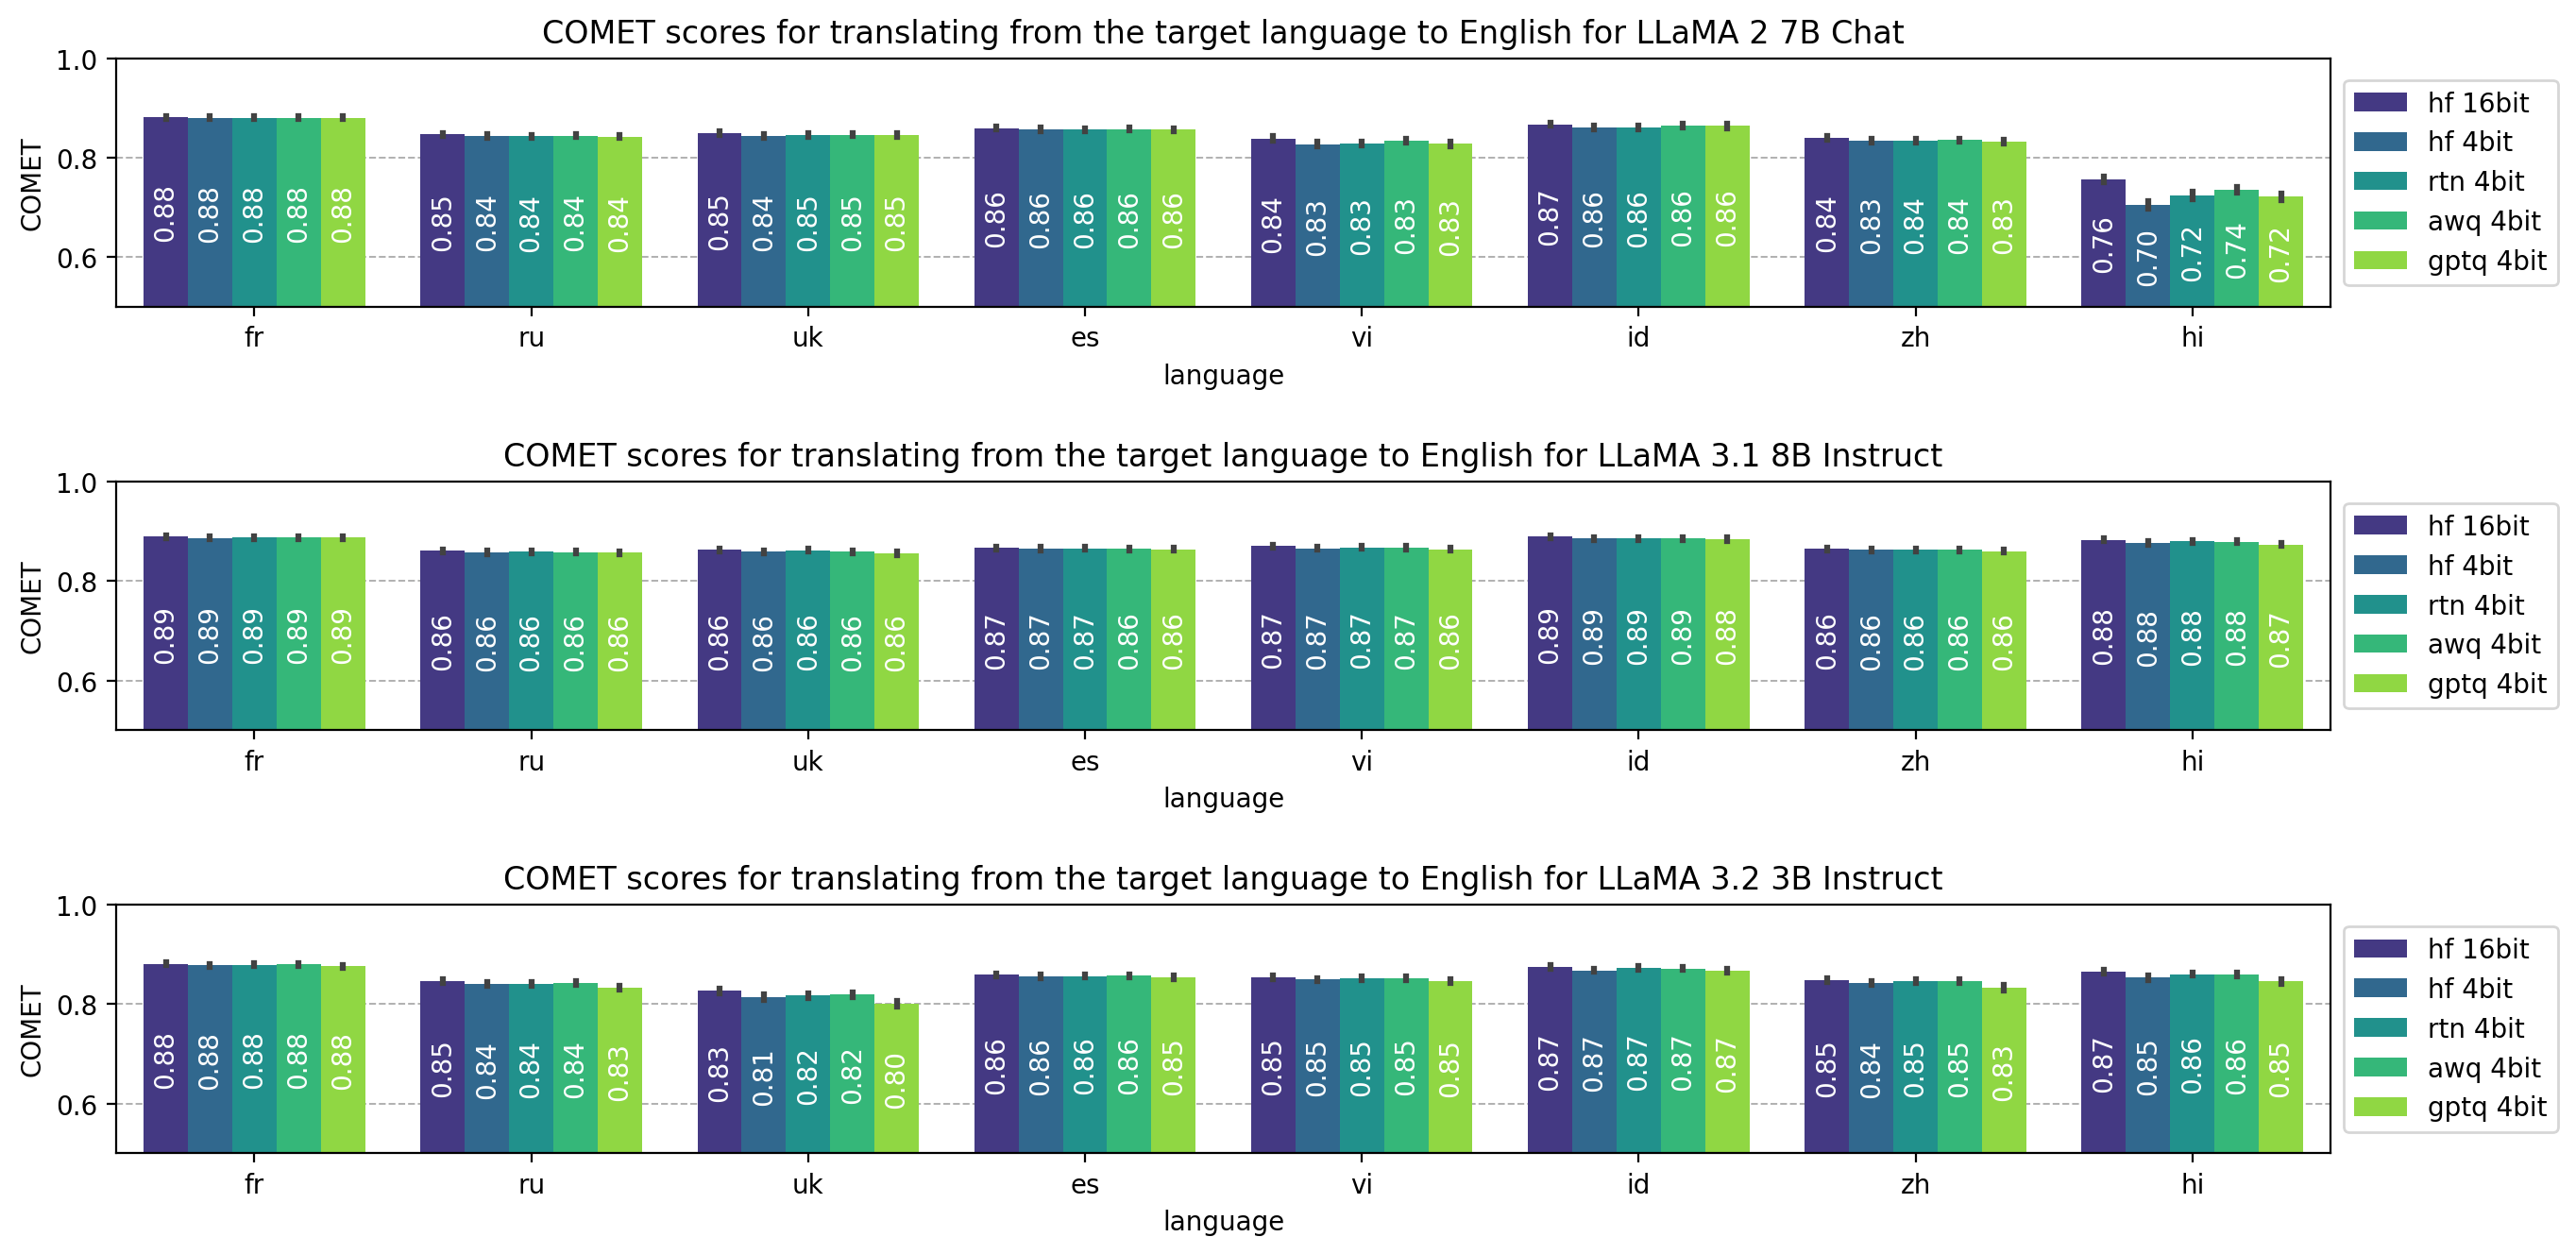

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(14, 7), dpi=200)

for n in range(3):
    ax = axs[n]
    comet_summary_avg = comets[n]
    m_name = model_names[n]

    ax = sns.barplot(x="language", y="COMET", hue="quant", palette="viridis", data=comet_summary_avg[comet_summary_avg["direction"]=="from"], saturation=1, ax=ax)
    for container in ax.containers:
        labels = ax.bar_label(container, label_type="center", color="white", fmt='%.2f')
        for label in labels:
            label.set_rotation(90)
    ax.set_ylim(0.5, 1)
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
    ax.set_axisbelow(True)
    ax.set_title(f"COMET scores for translating from the target language to English for {m_name}")

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(pad=2.0)
plt.show()